In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModel, AutoTokenizer
import random
import numpy as np
import itertools
import pickle
from tqdm import tqdm
import csv
import re
import pandas as pd

/home/leadawon5/gitfiles/venvs/vpvenv/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42) # Seed 고정

In [11]:
MODEL_NAME = "MickyMike/graphcodebert-c"
MODEL_TAG = "MickyMike_graphcodebert-c"
root_dir = "/home/leadawon5/decs_jupyter_lab/gitfiles/DACON/code_similarity/bigdata/train_code" 

class CodeEncoder(nn.Module):
    def __init__(self, model_name=MODEL_NAME):
        super(CodeEncoder, self).__init__()
        self.encoder = AutoModel.from_pretrained(model_name)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.pooler_output  # Use the pooled output






In [12]:
class CodeComparisonModel(nn.Module):
    def __init__(self, encoder_model_name):
        super(CodeComparisonModel, self).__init__()
        self.encoder = CodeEncoder(encoder_model_name)
        # 두 임베딩을 결합한 후 사용할 추가적인 레이어를 정의합니다.
        self.fc = nn.Linear(self.encoder.encoder.config.hidden_size * 2, 1)

    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2):
        embedding1 = self.encoder(input_ids1, attention_mask1)
        embedding2 = self.encoder(input_ids2, attention_mask2)
        # 두 임베딩을 결합합니다.
        combined_embedding = torch.cat((embedding1, embedding2), 1)
        # 결합된 임베딩을 추가적인 레이어에 통과시켜 이진 분류를 위한 로짓을 예측합니다.
        logits = self.fc(combined_embedding)
        # Sigmoid 함수를 적용하여 확률 값으로 변환
        probabilities = torch.sigmoid(logits)
        return probabilities.squeeze(-1)




In [13]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)



In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CodeComparisonModel(MODEL_NAME).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

Some weights of the model checkpoint at MickyMike/graphcodebert-c were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at MickyMike/graphcodebert-c and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
def load_checkpoint(model, optimizer, filepath):
    if os.path.exists(filepath):
        checkpoint = torch.load(filepath)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        step = checkpoint.get('step', 0)  # Default to 0 if not found
        print(f"Checkpoint loaded from {filepath} at epoch {epoch}, step {step}")
        return epoch, step
    else:
        print("No checkpoint found at specified path!")
        return None, None


# 체크포인트 파일 경로 지정
checkpoint_path = "./model/MickyMike_graphcodebert-c_checkpoint_epoch_0_step_180000.pth"

# 체크포인트 불러오기
epoch, step = load_checkpoint(model, optimizer, checkpoint_path)

Checkpoint loaded from ./model/MickyMike_graphcodebert-c_checkpoint_epoch_0_step_180000.pth at epoch 0, step 180000


In [16]:
def remove_comments(cpp_code):
        # 멀티라인 주석 제거
        code = re.sub(r'/\*.*?\*/', '', cpp_code, flags=re.DOTALL)
        # 단일 라인 주석 제거
        code = re.sub(r'//.*', '', code)
        
        # 문자열 내용 제거 (" " 안의 내용과 ' ' 안의 내용)
        code = re.sub(r'"(.*?)"', '""', code)
        code = re.sub(r"'(.*?)'", "''", code)
        # 빈 줄 제거
        code = re.sub(r'\n\s*\n', '\n', code)
        # 불필요한 공백 및 탭 변환 (연속된 공백을 하나의 공백으로)
        code = re.sub(r'\s+', ' ', code)
        # 문자열 앞뒤 공백 제거
        cleaned_code = code.strip()
        
        return cleaned_code


In [17]:
def predict(model, tokenizer, test_data, device, threshold=0.5):
    model.eval()  # 모델을 평가 모드로 설정
    model.to(device)  # 모델을 적절한 디바이스로 이동
    probs = []
    
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for index, row in tqdm(test_data.iterrows(), total=test_data.shape[0]):
            # 코드 쌍을 토큰화하고 적절한 디바이스로 이동합니다.
            text1 = remove_comments(row['code1'])
            text2 = remove_comments(row['code2'])
            inputs1 = tokenizer(text1, return_tensors='pt', max_length=512, padding='max_length', truncation=True).to(device)
            inputs2 = tokenizer(text2, return_tensors='pt', max_length=512, padding='max_length', truncation=True).to(device)
            
            # 모델을 통해 확률을 계산합니다.
            probability = model(inputs1['input_ids'], inputs1['attention_mask'], inputs2['input_ids'], inputs2['attention_mask'])
            
            # 설정한 임계값을 기준으로 유사 여부를 판단합니다.
            probs.append(probability)
    
    return probs

# 예제 사용
test_data = pd.read_csv("./bigdata/test.csv")
# 모델과 tokenizer가 정의되어 있어야 합니다.
probabilities = predict(model, tokenizer, test_data, device, threshold=0.5)




100%|█████████████████████████████████| 595000/595000 [6:13:40<00:00, 26.54it/s]


In [18]:
np_prob = [t.cpu().item() for t in probabilities]

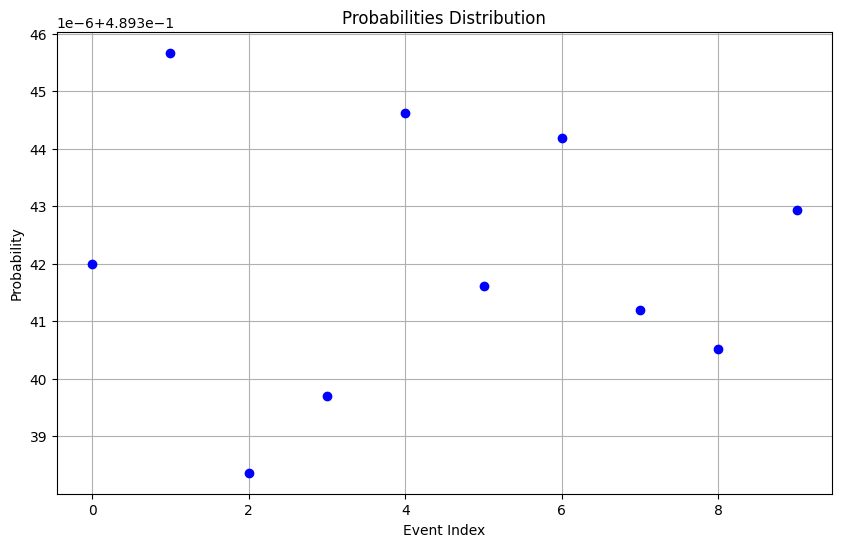

In [19]:
import matplotlib.pyplot as plt

# 리스트의 인덱스를 x축으로, 확률값을 y축으로 사용
plt.figure(figsize=(10, 6))
plt.plot(np_prob[:10], marker='o', color='b', linestyle='none')

# 그래프 제목 및 축 라벨 설정
plt.title('Probabilities Distribution')
plt.xlabel('Event Index')
plt.ylabel('Probability')

# 그리드 추가
plt.grid(True)

# 그래프 표시
plt.show()

In [20]:
threshold = np.median(np.array(np_prob))
threshold

0.4893421232700348

In [21]:
#predictions = 1 if probabilities > threshold else 0

predictions = [1 if p > threshold else 0 for p in np_prob]


In [22]:
# 결과를 제출 파일로 저장
submission = pd.read_csv('./bigdata/sample_submission.csv')
submission['similar'] = predictions
submission.to_csv(f'./bigdata/{MODEL_TAG}_predictions_submit.csv', index=False)

In [23]:
submission.head()

,pair_id,similar
0,TEST_000000,0
1,TEST_000001,1
2,TEST_000002,0
3,TEST_000003,0
4,TEST_000004,1
